In [1]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import nibabel as nib

from utils.unet_utils import DiceLoss, FocalLoss
from utils.data_loader import data_loader
from models.unet_3d import Unet

In [2]:
print(torch.version.cuda)
print(torch.cuda.is_available())

11.7
True


In [2]:
raw_img = "./data/raw_test.nii.gz"
seg_img = "./data/seg_test.nii.gz"

In [3]:
patch_size = (64,64,64)
patch_step = 64
in_chan = 1
out_chan = 1
filter_num = 32
learning_rate = 1e-3
epoch_num = 2
step_num = 270
    

model = Unet(in_chan, out_chan, filter_num)
criterion = FocalLoss()
metric = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)


In [4]:
# traning loop
for epoch in tqdm(range(epoch_num)):
    patch_gen = data_loader(raw_img, seg_img, patch_size, patch_step)
    for step in tqdm(range(step_num)): 
        
        image, label = next(patch_gen)

        # Forward pass
        output = model(image.unsqueeze(0))
        loss = criterion(output, label)
        score = metric(output, label)
        loss += 1 - score

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (step+1) % 10 == 0:
            print(f' Epoch [{epoch+1}/{epoch_num}], Step [{step+1}/{step_num}], Loss: {loss.item():.4f}')

print("Finished Training")
   

  0%|          | 0/2 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# save the model
torch.save(model.state_dict(), "./saved_models/unet")

In [ ]:
#load the model
load_model = Unet(in_chan, out_chan, filter_num)
load_model.load_state_dict(torch.load("./saved_models/unet"))
load_model.eval()

Unet(
  (conv): ConvBlock(
    (convb): Sequential(
      (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (EncB1): EncBlock(
    (encoder): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ConvBlock(
        (convb): Sequential(
          (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (4): BatchNorm3d(64, 

In [3]:
from patchify import patchify, unpatchify
import numpy as np
import matplotlib.pyplot as plt

In [4]:
raw_arr = nib.load(raw_img).get_fdata() # (1080*1280*52)
seg_arr = nib.load(seg_img).get_fdata()

In [ ]:
def aug(img, msk, thickness):
    """
    :params img: input 3D image
    :params msk: imput 3D mask
    :params thickness: expected augmented thickness of the data (in z-direction)
    """

    diff = thickness - img.shape[2]
    return np.concatenate((img, img[:,:,0:diff]), axis=2), np.concatenate((msk, msk[:,:,0:diff]), axis=2)

In [ ]:
new_raw, new_seg = aug(raw_arr[64:1024, 64:1216, :], seg_arr[64:1024, 64:1216, :], 64)
print(new_raw.shape)

(960, 1152, 64)


In [ ]:
test_patches = patchify(new_raw, (64,64,64), 64)

In [ ]:
test_patches.shape

(15, 18, 1, 64, 64, 64)

In [ ]:
# Predict each 3D patch  


for i in tqdm(range(test_patches.shape[0])):
  for j in range(test_patches.shape[1]):
    for k in range(test_patches.shape[2]):
      #print(i,j,k)
      single_patch = test_patches[i,j,k, :,:,:]
      single_patch_input = np.expand_dims(single_patch, axis=0)
      single_patch_input = torch.from_numpy(single_patch_input).to(torch.float32).unsqueeze(0)

      single_patch_prediction = load_model(single_patch_input)

      single_patch_prediction_sigmoid = torch.sigmoid(single_patch_prediction)
      single_patch_prediction_sigmoid = single_patch_prediction_sigmoid.detach().numpy()[0,0,:,:,:]
      
      test_patches[i,j,k, :,:,:] = single_patch_prediction_sigmoid

100%|██████████| 15/15 [05:36<00:00, 22.45s/it]


In [ ]:
test_output = unpatchify(test_patches, (new_raw.shape[0],new_raw.shape[1],new_raw.shape[2]))

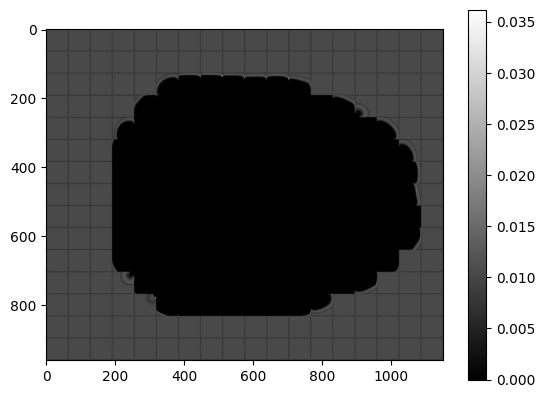

In [ ]:
plt.figure()
plt.imshow(test_output[:,:,0], cmap="gray")
plt.colorbar()

In [ ]:
#Reshape to the shape we had after patchifying
predicted_patches_reshaped = np.reshape(predicted_patches, 
                                        (patches.shape[0], patches.shape[1], patches.shape[2],
                                         patches.shape[3], patches.shape[4], patches.shape[5]) )
print(predicted_patches_reshaped.shape)